In [1]:
from h5py import File as HDF5File
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = torch.device('cuda:0')

# Load data

Data is stored in `.npz`-format which is a special file type for persisting multiple NumPy arrays on disk(ore info: https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.format.html#module-numpy.lib.format).

File contains three arrays: 

  * `EnergyDeposit` - images of calorimeters responses
  * `ParticleMomentum` - $p_x, p_y, p_z$ of initial partice
  * `ParticlePoint` - $x, y$ of initial particle

In [2]:
data_real = np.load('../real_quan.npz', allow_pickle=True)
EnergyDeposit = data_real['EnergyDeposit']
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)
ParticleMomentum = data_real['ParticleMomentum']
ParticlePoint = data_real['ParticlePoint']

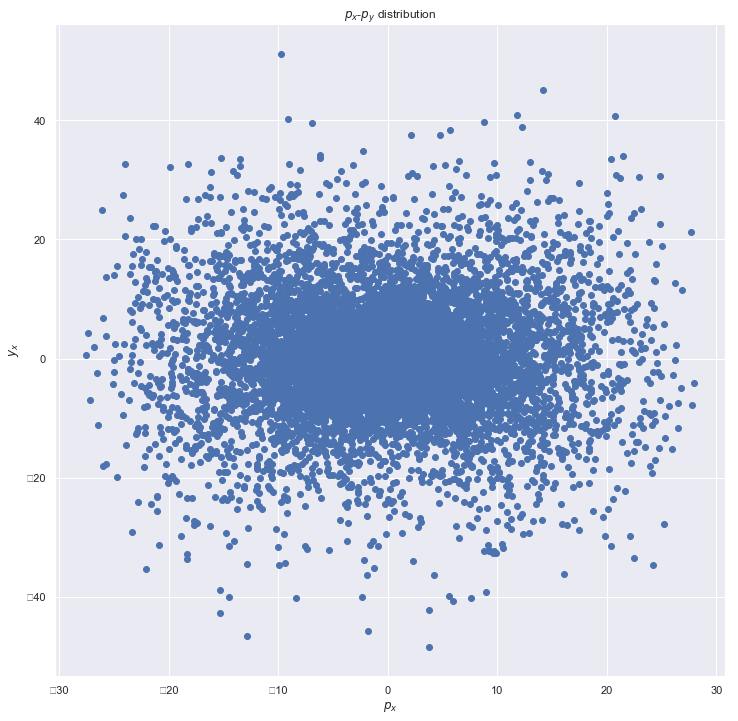

In [3]:
plt.figure(figsize=(12, 12))
plt.title('$p_x$-$p_y$ distribution')
plt.scatter(ParticleMomentum[:, 0], ParticleMomentum[:, 1]);
plt.xlabel('$p_x$')
plt.ylabel('$y_x$')
plt.show()

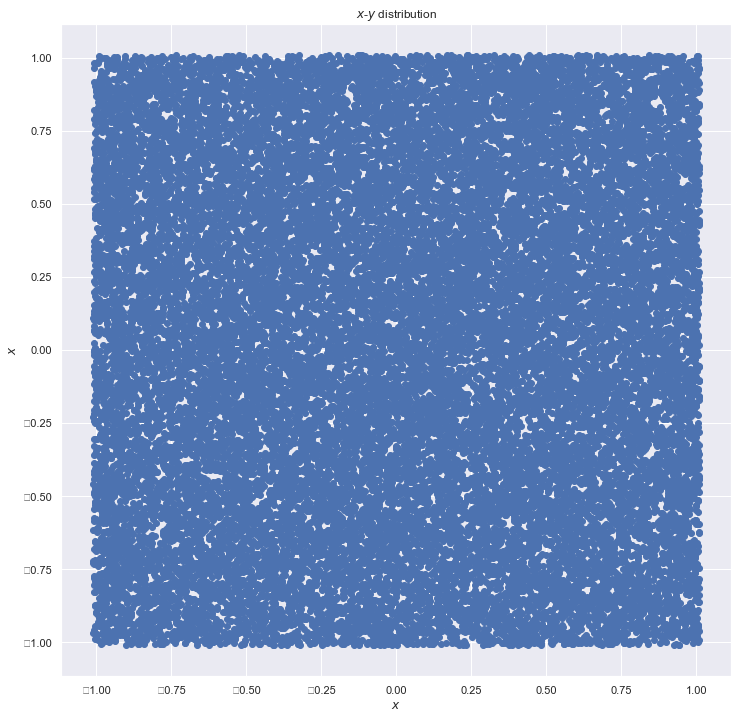

In [4]:
plt.figure(figsize=(12, 12))
plt.title('$x$-$y$ distribution')
plt.scatter(ParticlePoint[:, 0], ParticlePoint[:, 1]);
plt.xlabel('$x$')
plt.ylabel('$x$')
plt.show()

In [5]:
ParticleMomentum = ParticleMomentum[:, :2]
ParticlePoint = ParticlePoint[:, :2]

# Load it to pytorch `DataLoader` for faster inference

In [6]:
EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()

BATCH_SIZE = 1024
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)

# Defining our neural network regressor

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.conv4 = nn.Conv2d(64, 64, 2)
        
        self.fc1 = nn.Linear(1600, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2 + 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x)) # 64, 5, 5
        x = x.view(len(x), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [8]:
regressor = Regressor().to(device)

# Defining optimizer

In [9]:
learning_rate = 1e-3
opt = optim.Adam(regressor.parameters(), lr=learning_rate)

## Relative MSE that is used in competition

In [10]:
ParticleMomentum_mean, ParticlePoint_mean = ParticleMomentum.mean(dim=0), ParticlePoint.mean(dim=0)
ParticleMomentum_ParticlePoint_mean = torch.cat([ParticleMomentum_mean, ParticlePoint_mean]).to(device)
def metric_relative_mse(y_true, y_pred):
    return ((y_true - y_pred).pow(2).mean(dim=0) / (y_true - ParticleMomentum_ParticlePoint_mean).pow(2).mean(dim=0)).sum()

# Loss function

In [11]:
loss_fn = torch.nn.L1Loss().to(device)

In [12]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [15]:
def run_training(epochs=100):
    losses = []
    metrics = []
    loss_meter = RunningAverageMeter(momentum=0.99)
    metric_meter = RunningAverageMeter(momentum=0.99)
    for epoch in tqdm(range(epochs)):
        for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
            EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                                   ParticleMomentum_b.to(device), \
                                                                   ParticlePoint_b.to(device)
            pred = regressor(EnergyDeposit_b)

            loss = loss_fn(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1))
            losses.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item())
            metric_meter.update(metric_relative_mse(pred, torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)).item())
            losses.append(loss_meter.avg)
            metrics.append(metric_meter.avg)

                
        clear_output()
        plt.figure(figsize=(12, 12))
        plt.plot(losses, label='Loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(12, 12))
        plt.plot(metrics, label='Metric')
        plt.legend()
        plt.show()

In [ ]:
run_training(10)

## Make predictions for validation set

In [16]:
data_val = np.load('./data_val.npz', allow_pickle=True)
EnergyDeposit_val = data_val['EnergyDeposit']
EnergyDeposit_val = EnergyDeposit_val.reshape(-1, 1, 30, 30)

In [21]:
prediction_val = regressor.cpu()(torch.tensor(EnergyDeposit_val).float())

In [24]:
ParticleMomentum_val, ParticlePoint_val = prediction_val.detach().numpy()[:, :2], prediction_val.detach().numpy()[:, 2:]

In [25]:
np.savez_compressed('data_val_prediction.npz', 
                    ParticlePoint=ParticlePoint_val, 
                    ParticleMomentum=ParticleMomentum_val)

## Make predictions for test set

In [ ]:
data_test = np.load('./data_test.npz', allow_pickle=True)
EnergyDeposit_test = data_test['EnergyDeposit']
EnergyDeposit_test = EnergyDeposit_test.reshape(-1, 1, 30, 30)

In [ ]:
prediction_test = regressor.cpu()(torch.tensor(EnergyDeposit_test).float())

In [ ]:
ParticleMomentum_test, ParticlePoint_test = predictio_test.detach().numpy()[:, :2], predictio_test.detach().numpy()[:, 2:]

In [ ]:
np.savez_compressed('data_test_prediction.npz', 
                    ParticlePoint=ParticlePoint_test, 
                    ParticleMomentum=ParticleMomentum_test)

## `zip` files together

In [ ]:
!zip solution.zip data_val_prediction.npz ata_test_prediction.npz

In [ ]:
from IPython.display import FileLink
FileLink('./solution.zip')